# Створення нейронної мережі

У цьому завданні ми створимо повнозв'язну нейронну мережу, використовуючи при цьому низькорівневі механізми tensorflow.

Архітектура нейромережі представлена на наступному малюнку. Як бачиш, у ній є один вхідний шар, два приховані, а також вихідний шар. В якості активаційної функції у прихованих шарах буде використовуватись сигмоїда. На вихідному шарі ми використовуємо softmax.

Частина коду зі створення мережі вже написана, тобі потрібно заповнити пропуски у вказаних місцях.

## Архітектура нейронної мережі

<img src="http://cs231n.github.io/assets/nn1/neural_net2.jpeg" alt="nn" style="width: 400px;"/>


## Про датасет MNIST

Дану нейромережу ми будемо вивчати на датасеті MNIST. Цей датасет являє собою велику кількість зображень рукописних цифр розміром $28 \times 28$ пікселів. Кожен піксель приймає значення від 0 до 255.

Як і раніше, датасет буде розділений на навчальну та тестову вибірки. При цьому ми виконаємо нормалізацію всіх зображень, щоб значення пікселів знаходилось у проміжку від 0 до 1, розділивши яскравість кожного пікселя на 255.

Окрім того, архітектура нейронної мережі очікує на вхід вектор. У нашому ж випадку кожен об'єкт вибірки являє собою матрицю. Що ж робити? У цьому завданні ми "розтягнемо" матрицю $28 \times 28$, отримавши при цьому вектор, що складається з 784 елементів.

![MNIST Dataset](https://www.researchgate.net/profile/Steven-Young-5/publication/306056875/figure/fig1/AS:393921575309346@1470929630835/Example-images-from-the-MNIST-dataset.png)

Більше інформації про датасет можна знайти [тут](http://yann.lecun.com/exdb/mnist/).

In [1]:
# Встановлення необхідних бібліотек
%pip install tensorflow numpy pandas matplotlib seaborn scikit-learn keras

# Імпорт бібліотек
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.datasets import mnist
from sklearn.metrics import confusion_matrix, classification_report



[notice] A new release of pip is available: 24.1.2 -> 24.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached seaborn-0.13.2-py3-none-any.whl.metadata (5.4 kB)
  Using cached keras-3.5.0-py3-none-any.whl.metadata (5.8 kB)
  Using cached absl_py-2.1.0-py3-none-any.whl.metadata (2.3 kB)
  Using cached astunparse-1.6.3-py2.py3-none-any.whl.metadata (4.4 kB)
  Using cached flatbuffers-24.3.25-py2.py3-none-any.whl.metadata (850 bytes)
  Using cached gast-0.6.0-py3-none-any.whl.metadata (1.3 kB)
  Using cached google_pasta-0.2.0-py3-none-any.whl.metadata (814 bytes)
  Using cached libclang-18.1.1-py2.py3-none-win_amd64.whl.metadata (5.3 kB)
  Using cached opt_einsum-3.3.0-py3-none-any.whl.metadata (6.5 kB)
  Using cached protobuf-4.25.4-cp310-abi3-win_amd64.whl.metadata (541 bytes)
  Using cached termcolor-2.4.0-py3-none-any.whl.metadata (6.1 kB)
  Using cached tensorboard-2.17.1-py3-none-any.whl.metadata (1.6 kB)
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     ---------------------------------------- 61.0/61.0 kB 3.2 MB/s eta 0:00:00
  Using cached cycler

In [2]:
# Основні параметри моделі
num_classes = 10  # Загальна кількість класів (цифри від 0 до 9)
num_features = 784  # Кількість атрибутів вхідного вектора (28 * 28 = 784)

learning_rate = 0.001  # Швидкість навчання нейронної мережі
training_steps = 3000  # Максимальне число епох
batch_size = 256  # Розмір підмножини для кожної ітерації навчання
display_step = 100  # Кількість ітерацій між виведенням результатів

n_hidden_1 = 128  # Кількість нейронів у першому прихованому шарі
n_hidden_2 = 256  # Кількість нейронів у другому прихованому шарі


In [3]:
# from tensorflow.keras.datasets import mnist
from keras.datasets import mnist

# Завантажуємо датасет
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Перетворюємо цілочисельні пікселі на тип float32
x_train, x_test = np.array(x_train, np.float32), np.array(x_test, np.float32)

# Перетворюємо матриці розміром 28x28 пікселів у вектор з 784 елементів
x_train, x_test = x_train.reshape([-1, num_features]), x_test.reshape([-1, num_features])

# Нормалізуємо значення пікселів
x_train, x_test = x_train / 255., x_test / 255.

# Перемішаємо тренувальні дані
train_data = tf.data.Dataset.from_tensor_slices((x_train, y_train))
train_data = train_data.repeat().shuffle(5000).batch(batch_size).prefetch(1)

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [4]:
class DenseLayer(tf.Module):
    def __init__(self, in_features, out_features, name=None):
        super().__init__(name=name)
        self.w = tf.Variable(tf.random.normal([in_features, out_features]), name="w")
        self.b = tf.Variable(tf.zeros([out_features]), name="b")

    def __call__(self, x, activation=0):
        y = tf.matmul(x, self.w) + self.b
        if activation == 1:  # 1 для вихідного шару
            return tf.nn.softmax(y)
        else:
            return tf.nn.sigmoid(y)


class NN(tf.Module):
    def __init__(self, name=None):
        super().__init__(name=name)
        self.layer1 = DenseLayer(num_features, n_hidden_1)
        self.layer2 = DenseLayer(n_hidden_1, n_hidden_2)
        self.out_layer = DenseLayer(n_hidden_2, num_classes)

    def __call__(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.out_layer(x, activation=1)  # Softmax на вихідному шарі
        return x


In [5]:
def cross_entropy(y_pred, y_true):
    y_true = tf.one_hot(y_true, depth=num_classes)
    y_pred = tf.clip_by_value(y_pred, 1e-9, 1.)
    return tf.reduce_mean(-tf.reduce_sum(y_true * tf.math.log(y_pred), axis=1))


def accuracy(y_pred, y_true):
    correct_prediction = tf.equal(tf.argmax(y_pred, 1), tf.argmax(y_true, 1))
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))


In [9]:
# Створюємо модель
neural_net = NN()

# Ініціалізуємо оптимізатор після створення моделі
optimizer = tf.optimizers.Adam(learning_rate)

# Функція для оновлення вагів
def run_optimization(x, y):
    with tf.GradientTape() as g:
        pred = neural_net(x)
        loss = cross_entropy(pred, y)
    gradients = g.gradient(loss, neural_net.trainable_variables)
    optimizer.apply_gradients(zip(gradients, neural_net.trainable_variables))



In [18]:
def accuracy(y_pred, y_true):
    # Перетворюємо y_pred в індекси класів
    y_pred = tf.argmax(y_pred, axis=1)
    
    # Приводимо y_true до типу int64 для порівняння з y_pred
    y_true = tf.cast(y_true, tf.int64)
    
    # Порівнюємо y_pred з y_true
    correct_prediction = tf.equal(y_pred, y_true)
    return tf.reduce_mean(tf.cast(correct_prediction, tf.float32))




step: 100, loss: 2.3935, accuracy: 0.5234
step: 200, loss: 0.9911, accuracy: 0.7656
step: 300, loss: 1.0450, accuracy: 0.7148
step: 400, loss: 0.8783, accuracy: 0.7812
step: 500, loss: 0.5461, accuracy: 0.8594
step: 600, loss: 0.6493, accuracy: 0.8164
step: 700, loss: 0.5721, accuracy: 0.8281
step: 800, loss: 0.4472, accuracy: 0.8789
step: 900, loss: 0.4153, accuracy: 0.8789
step: 1000, loss: 0.3563, accuracy: 0.8945
step: 1100, loss: 0.5008, accuracy: 0.8789
step: 1200, loss: 0.3707, accuracy: 0.8906
step: 1300, loss: 0.2624, accuracy: 0.9102
step: 1400, loss: 0.3085, accuracy: 0.9219
step: 1500, loss: 0.3749, accuracy: 0.9141
step: 1600, loss: 0.3320, accuracy: 0.9023
step: 1700, loss: 0.2429, accuracy: 0.9141
step: 1800, loss: 0.3119, accuracy: 0.9023
step: 1900, loss: 0.1632, accuracy: 0.9492
step: 2000, loss: 0.3375, accuracy: 0.9258
step: 2100, loss: 0.2173, accuracy: 0.9453
step: 2200, loss: 0.2598, accuracy: 0.9297
step: 2300, loss: 0.2491, accuracy: 0.9219
step: 2400, loss: 0.

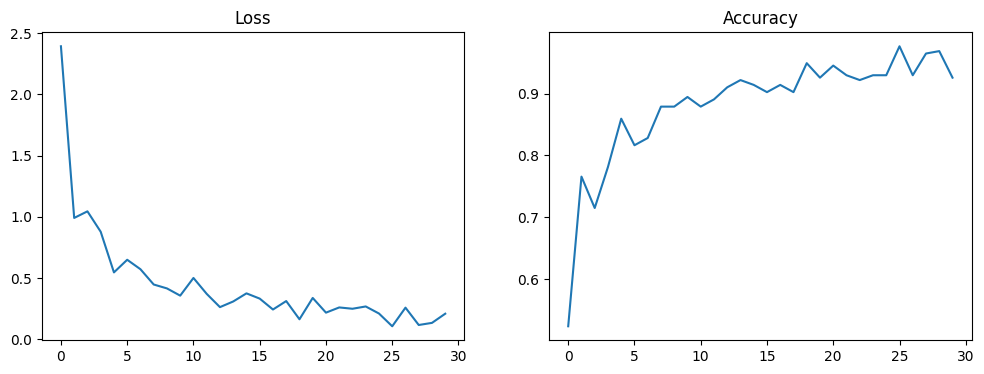

In [19]:
# Навчання моделі
neural_net = NN()

# Ініціалізуємо оптимізатор після створення моделі
optimizer = tf.optimizers.Adam(learning_rate)

loss_history = []
accuracy_history = []

for step, (batch_x, batch_y) in enumerate(train_data.take(training_steps), 1):
    run_optimization(batch_x, batch_y)

    if step % display_step == 0:
        pred = neural_net(batch_x)

        # Втрата
        loss = cross_entropy(pred, batch_y)
        
        # Обчислення точності
        acc = accuracy(pred, batch_y)
        
        loss_history.append(loss)
        accuracy_history.append(acc)
        
        print(f"step: {step}, loss: {loss:.4f}, accuracy: {acc:.4f}")

# Візуалізація графіків втрат і точності
plt.figure(figsize=(12, 4))

# Графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(loss_history)
plt.title('Loss')

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history)
plt.title('Accuracy')

plt.show()


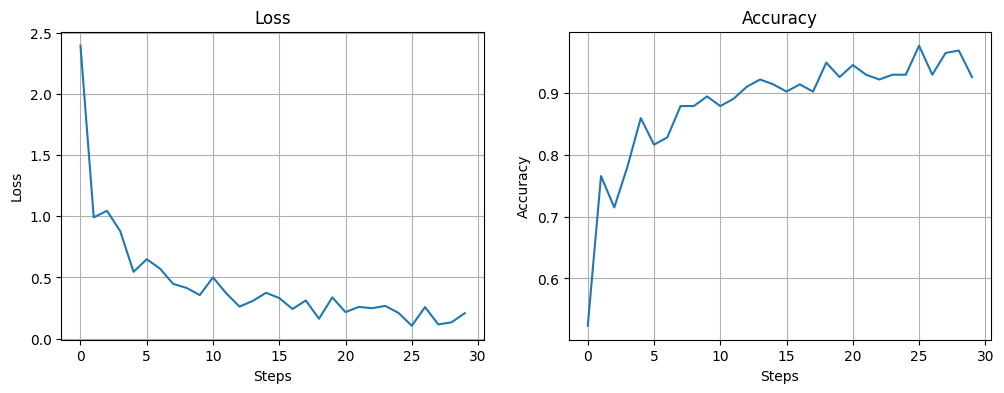

In [20]:
import matplotlib.pyplot as plt

# Виведення графіків залежності втрат і точності від кроків навчання
plt.figure(figsize=(12, 4))

# Графік функції втрат
plt.subplot(1, 2, 1)
plt.plot(loss_history, label='Loss')
plt.title('Loss')
plt.xlabel('Steps')
plt.ylabel('Loss')
plt.grid(True)

# Графік точності
plt.subplot(1, 2, 2)
plt.plot(accuracy_history, label='Accuracy')
plt.title('Accuracy')
plt.xlabel('Steps')
plt.ylabel('Accuracy')
plt.grid(True)

plt.show()


Test Accuracy: 0.9215


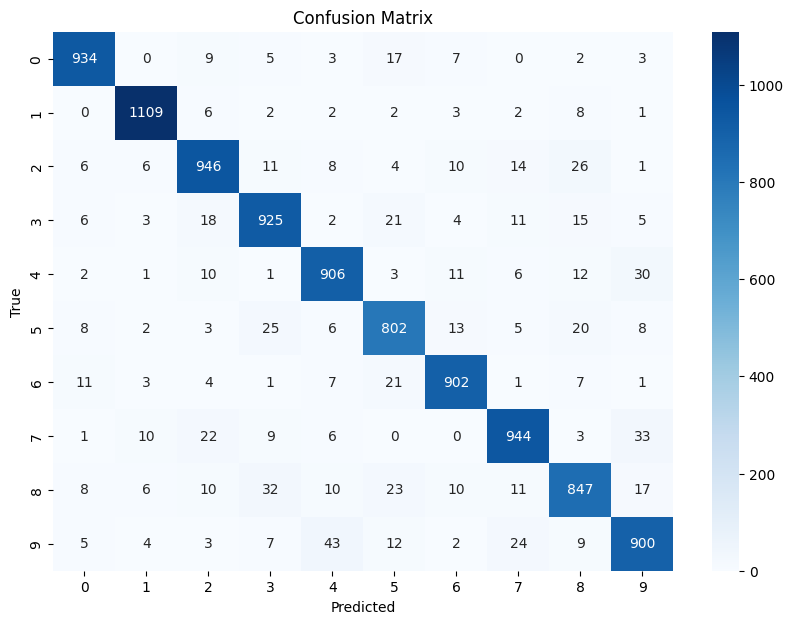

Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       980
           1       0.97      0.98      0.97      1135
           2       0.92      0.92      0.92      1032
           3       0.91      0.92      0.91      1010
           4       0.91      0.92      0.92       982
           5       0.89      0.90      0.89       892
           6       0.94      0.94      0.94       958
           7       0.93      0.92      0.92      1028
           8       0.89      0.87      0.88       974
           9       0.90      0.89      0.90      1009

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [23]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Передбачення на тестових даних
pred_test = neural_net(x_test)

# Перетворення передбачень на класи
y_pred_test = tf.argmax(pred_test, axis=1)

# Перевіряємо, чи y_test має одну розмірність (тобто це вже індекси класів)
if len(y_test.shape) > 1:
    # Якщо y_test має форму (batch_size, num_classes), потрібно застосувати argmax
    y_true_test = tf.argmax(y_test, axis=1)
else:
    # Якщо y_test має форму (batch_size,), то це вже індекси класів
    y_true_test = y_test

# Виведення точності на тестовій вибірці
test_accuracy = accuracy(pred_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")

# Виведення матриці плутанини
cm = confusion_matrix(y_true_test, y_pred_test)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Виведення звіту про класифікацію
print("Classification Report:")
print(classification_report(y_true_test, y_pred_test))



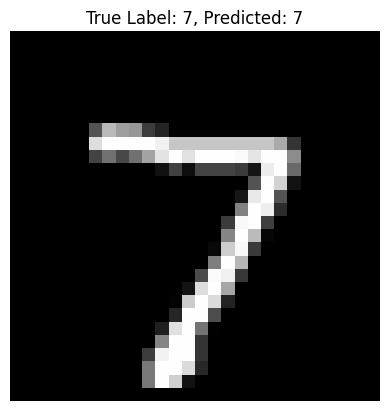

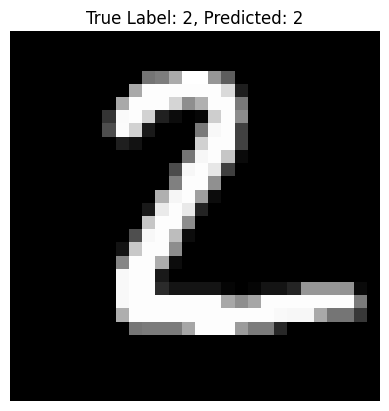

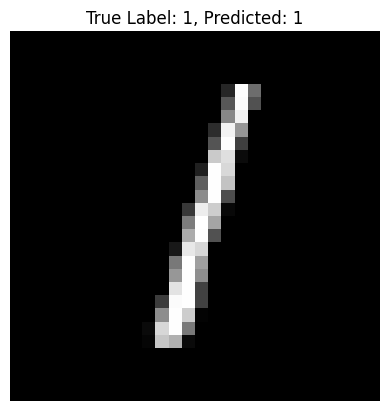

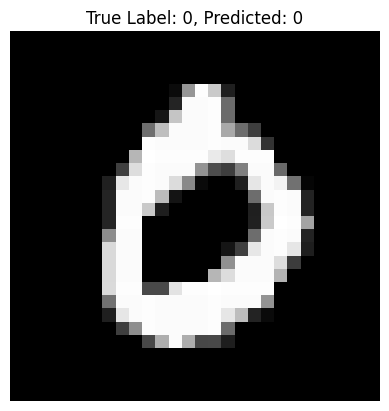

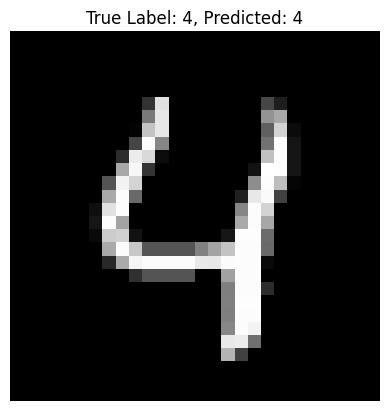

In [24]:
import numpy as np

# Вибірка кількох зображень з тестової вибірки
n_images = 5
test_images = x_test[:n_images]
test_labels = y_true_test[:n_images]  # Використовуємо y_true_test з 9-ї комірки

# Передбачення для вибраних зображень
predictions = neural_net(test_images)
predicted_classes = tf.argmax(predictions, axis=1)

# Виведення результатів
for i in range(n_images):
    plt.imshow(np.reshape(test_images[i], [28, 28]), cmap='gray')
    plt.title(f"True Label: {test_labels[i]}, Predicted: {predicted_classes[i].numpy()}")
    plt.axis('off')
    plt.show()
